In [1]:
# univariate cnn lstm example
from numpy import array
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras import optimizers

import numpy
import matplotlib.pyplot as plt
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
from pandas import read_csv
from math import sqrt


# split a univariate sequence into samples

def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def train_test (n_steps_in, n_steps_out, propTrainTest, dataset):
    
    n_steps_in, n_steps_out = n_steps_in, n_steps_out
    # split train test
    X, y = split_sequence(dataset, n_steps_in, n_steps_out)
    
    train_size = int(len(X) * propTrainTest)
    test_size = len(dataset) - train_size
    train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]
    train_Y, test_Y = y[0:train_size,:], y[train_size:len(y),:]
    
    return (train_X, test_X, train_Y, test_Y)

# fixem random seed
numpy.random.seed(7)

dadesSau = read_csv('dadesBaells.csv', sep=';',header=0, index_col=0)
dataframe = pd.DataFrame(dadesSau.loc[dadesSau.index >= '2009-01-01']['Volum'])
dataset = dataframe.values
dataset = dataset.astype('float32')

# Normalitzem

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset = [item for sublist in dataset for item in sublist]

n_steps_in = 30
n_steps_out = 15
propTrainTest = 0.8
train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, dataset)

# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
#train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
#test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calcul global de RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

Optimtizem learning rate i batch size

In [8]:
# define model
model_list=[]
lr=np.arange(0.0001,0.01,0.0005)
batch=[8,16,32,64,128]
resultatsf=[]
for learn in lr:
    adam = optimizers.Adam(lr=learn)
    resultat=[]
    for batch_size in batch:
        model = Sequential()
        model.add(Dense(26, activation='sigmoid', input_dim=n_steps_in))
        model.add(Dense(n_steps_out))
        model.compile(loss='mse', optimizer=adam)
        # fit model
        modelfit = model.fit(train_X, train_Y, epochs=500, batch_size=batch_size, verbose=0)
        trainPredict = model.predict(train_X)
        testPredict = model.predict(test_X)
        # invertim prediccions per tenir-les en l'escala original
        trainPredict = scaler.inverse_transform(trainPredict)
        train_YR = scaler.inverse_transform(train_Y)
        testPredict = scaler.inverse_transform(testPredict)
        test_YR = scaler.inverse_transform(test_Y)
        RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
        print(RMSE_TOT)
        resultat.append((learn, batch_size,RMSE_days,RMSE_TOT))
    
    resultatsf.append(resultat)

2.8309489962957746
2.8679095814732616
2.9570911234544273
3.121836744164121
3.3358707431510624
2.7042314689327407
2.7017329578610885
2.715123233773115
2.7381401022045573
2.8386573005806763
5.287508770821814
3.486029037736992
2.8887830651108457
2.691015807842075
2.7428030500531566
36.06383073814554
14.596964368032587
2.9685675320496903
2.7364669302249203
4.386019648878583
51.81711296188541
39.36121764624496
7.505990774396183
13.82319457895332
2.857710137889378
48.22779788483974
36.24780173620724
39.207443557615505
3.140427668729237
2.6774388502423987
79.91019892496877
40.972110593659195
23.531341932511207
15.13787307641925
6.961630253698397
93.61304868271738
65.03066602854211
63.268081064410744
30.400923514691325
9.010539830352657
117.48623357309458
81.406488508114
66.48622243169055
22.385037563614873
9.655582136759197
196.04835001850049
75.89419762522955
95.28182822056974
48.78248350773305
15.302922582603715
206.46945794564562
100.52989333505089
42.31383788918813
20.797147060297643
24.7

In [9]:
resultatsEpDe = pd.DataFrame(resultatsf)

In [12]:
varlist = []
for i in range(len(lr)):
    resultatsEpDe = pd.DataFrame(resultatsf[i])
    varlist.append(resultatsEpDe)
    
resultFinal = pd.concat(varlist)
resultFinal.columns=['learning rate', 'batch size', 'RMSE_dies', 'RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]

,learning rate,batch size,RMSE_dies,RMSE_total
0,0.0026,128,"[0.8747382794380217, 1.0353740534977844, 1.230...",2.677439
1,0.0011,64,"[0.685494988806429, 0.975091390728102, 1.23407...",2.691016
2,0.0006,16,"[0.5710765997820288, 1.0228952616661744, 1.344...",2.701733
3,0.0006,8,"[0.6213623281893081, 1.0243973635175234, 1.294...",2.704231
4,0.0006,32,"[0.5897619178039972, 0.8788234756486457, 1.181...",2.715123
5,0.0016,64,"[0.8168702335700186, 1.0355191152586711, 1.350...",2.736467
6,0.0006,64,"[0.7486062212092123, 1.0601555820763775, 1.266...",2.738140
7,0.0011,128,"[0.7161180155582118, 1.0166487595799887, 1.253...",2.742803
8,0.0001,8,"[0.8332624683448734, 1.129493481448793, 1.3047...",2.830949
9,0.0006,128,"[0.9493199047302383, 1.0820975162857975, 1.374...",2.838657


In [14]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_days)):
    headers.append('dia '+str(i+1))

RMSE_days = resultFinal['RMSE_dies'][0]
print(RMSE_days)
headers.append('Total')
v = RMSE_days
ultim = v.append(resultFinal['RMSE_total'][0])
table1 = tabulate([RMSE_days[0:5]], headers[0:5], tablefmt="fancy_grid")
table2 = tabulate([RMSE_days[5:10]], headers[5:10], tablefmt="fancy_grid")
table3 = tabulate([RMSE_days[10:16]], headers[10:16], tablefmt="fancy_grid")
#output
print(table1)
print(table2)
print(table3)

[0.8747382794380217, 1.0353740534977844, 1.2303720587629658, 1.4907191376780453, 1.7486628464746625, 1.9891229732697038, 2.2487649706967194, 2.4811059328624907, 2.7410267169016347, 2.948892779998908, 3.190771331569947, 3.431198169754547, 3.6502266852650127, 3.883047177382075, 4.142963483225485, 2.6774388502423987]
╒══════════╤═════════╤═════════╤═════════╤═════════╕
│    dia 1 │   dia 2 │   dia 3 │   dia 4 │   dia 5 │
╞══════════╪═════════╪═════════╪═════════╪═════════╡
│ 0.874738 │ 1.03537 │ 1.23037 │ 1.49072 │ 1.74866 │
╘══════════╧═════════╧═════════╧═════════╧═════════╛
╒═════════╤═════════╤═════════╤═════════╤══════════╕
│   dia 6 │   dia 7 │   dia 8 │   dia 9 │   dia 10 │
╞═════════╪═════════╪═════════╪═════════╪══════════╡
│ 1.98912 │ 2.24876 │ 2.48111 │ 2.74103 │  2.94889 │
╘═════════╧═════════╧═════════╧═════════╧══════════╛
╒══════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│   dia 11 │   dia 12 │   dia 13 │   dia 14 │   dia 15 │   dia 16 │
╞══════════╪══════

In [16]:
model_list=[]
dense=np.arange(20,33,1)
epochs=[400,500,600]
resultatsf=[]
adam = optimizers.Adam(lr=0.0006)
for den in dense:
    resultat=[]
    for epoch in epochs:
        model = Sequential()
        model.add(Dense(den, activation='sigmoid', input_dim=n_steps_in))
        model.add(Dense(n_steps_out))
        model.compile(loss='mse', optimizer=adam)
        # fit model
        modelfit = model.fit(train_X, train_Y, epochs=epoch, batch_size=16, verbose=0)
        trainPredict = model.predict(train_X)
        testPredict = model.predict(test_X)
        # invertim prediccions per tenir-les en l'escala original
        trainPredict = scaler.inverse_transform(trainPredict)
        train_YR = scaler.inverse_transform(train_Y)
        testPredict = scaler.inverse_transform(testPredict)
        test_YR = scaler.inverse_transform(test_Y)
        RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
        print(RMSE_TOT)
        resultat.append((den,epoch,RMSE_days,RMSE_TOT))
    
    resultatsf.append(resultat)

2.7482874653146627
2.7918240866012263
2.687528282748904
2.6933308974595733
2.6543366873685343
2.6637505511086217
2.792942673588663
2.679946955962139
2.720516568707069
2.7010344188022337
2.6753760927571415
2.824679848902515
2.6968448910059113
2.673034896819476
2.7048210902880827
2.6878050987067117
2.682026417178501
2.725433435671369
2.727954876238038
2.694560799128724
2.67517271719389
2.6693128104107378
2.6914287818481637
2.6720191396425927
2.752190343516108
2.7967178768143564
2.682154544363671
2.691720893826091
2.6918188689988747
2.7144850639170555
2.6857187583243256
2.677595468487942
2.6524958491386186
2.675156592355063
2.6845437014181472
2.7789853649905143
2.726919726822421
2.784858017362872
2.677462702438058


In [18]:
resultatsEpDe = pd.DataFrame(resultatsf)

In [21]:
varlist = []
for i in range(len(dense)):
    resultatsEpDe = pd.DataFrame(resultatsf[i])
    varlist.append(resultatsEpDe)
    
resultFinal = pd.concat(varlist)
resultFinal.columns=['neurones', 'epochs', 'RMSE_dies', 'RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]

,neurones,epochs,RMSE_dies,RMSE_total
0,30,600,"[0.5438618073666186, 0.9180901954343414, 1.151...",2.652496
1,21,500,"[0.5609731615041926, 0.8250090078382303, 1.200...",2.654337
2,21,600,"[0.5405568405139144, 0.8826092511381819, 1.149...",2.663751
3,27,400,"[0.5349342554018299, 0.9161811467590664, 1.197...",2.669313
4,27,600,"[0.574304587247935, 0.8893958192641704, 1.1644...",2.672019
5,24,500,"[0.5582811507943741, 0.837974846437361, 1.1700...",2.673035
6,31,400,"[0.6681003552451158, 0.8759421657583613, 1.155...",2.675157
7,26,600,"[0.8625236742944592, 0.9629053884616331, 1.215...",2.675173
8,23,500,"[0.5503674840021887, 0.8482632551183497, 1.143...",2.675376
9,32,600,"[0.9262483279667434, 1.057587768483668, 1.2878...",2.677463


In [22]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_days)):
    headers.append('dia '+str(i+1))

RMSE_days = resultFinal['RMSE_dies'][0]
print(RMSE_days)
headers.append('Total')
v = RMSE_days
ultim = v.append(resultFinal['RMSE_total'][0])
table1 = tabulate([RMSE_days[0:5]], headers[0:5], tablefmt="fancy_grid")
table2 = tabulate([RMSE_days[5:10]], headers[5:10], tablefmt="fancy_grid")
table3 = tabulate([RMSE_days[10:16]], headers[10:16], tablefmt="fancy_grid")
#output
print(table1)
print(table2)
print(table3)

[0.5438618073666186, 0.9180901954343414, 1.1513875323723346, 1.4412133726178777, 1.6958552603588886, 1.9629184398293575, 2.2123629554503865, 2.4548688388135096, 2.7003501806288868, 2.9505625107670315, 3.1893792689894944, 3.4238245039734134, 3.6477311490021287, 3.889923645290036, 4.124896423889029]
╒══════════╤═════════╤═════════╤═════════╤═════════╕
│    dia 1 │   dia 2 │   dia 3 │   dia 4 │   dia 5 │
╞══════════╪═════════╪═════════╪═════════╪═════════╡
│ 0.543862 │ 0.91809 │ 1.15139 │ 1.44121 │ 1.69586 │
╘══════════╧═════════╧═════════╧═════════╧═════════╛
╒═════════╤═════════╤═════════╤═════════╤══════════╕
│   dia 6 │   dia 7 │   dia 8 │   dia 9 │   dia 10 │
╞═════════╪═════════╪═════════╪═════════╪══════════╡
│ 1.96292 │ 2.21236 │ 2.45487 │ 2.70035 │  2.95056 │
╘═════════╧═════════╧═════════╧═════════╧══════════╛
╒══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   dia 11 │   dia 12 │   dia 13 │   dia 14 │   dia 15 │   Total │
╞══════════╪══════════╪══════════╪═══

In [24]:
adam = optimizers.Adam(lr=0.0006)
model = Sequential()
model.add(Dense(30, activation='sigmoid', input_dim=n_steps_in))
model.add(Dense(n_steps_out))
model.compile(loss='mse', optimizer=adam)
        # fit model
modelfit = model.fit(train_X, train_Y, epochs=600, batch_size = 16, verbose=0)
        

In [25]:
testPredict = model.predict(test_X)
# invertim prediccions per tenir-les en l'escala original
testPredict = scaler.inverse_transform(testPredict)
test_YR = scaler.inverse_transform(test_Y)

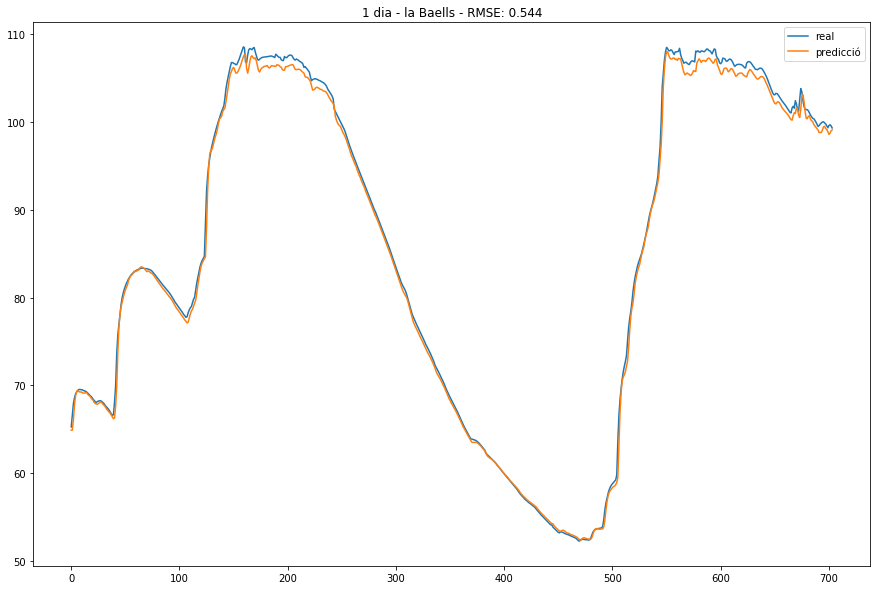

In [26]:
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - la Baells - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - la Baells - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - la Baells - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - la Baells - RMSE: '+str(round(RMSE_days[14],3))

plt.plot(dies[0][0], label='real')
plt.plot(dies[0][1], label='predicció')
plt.legend()
plt.title(title1)


plt.show()

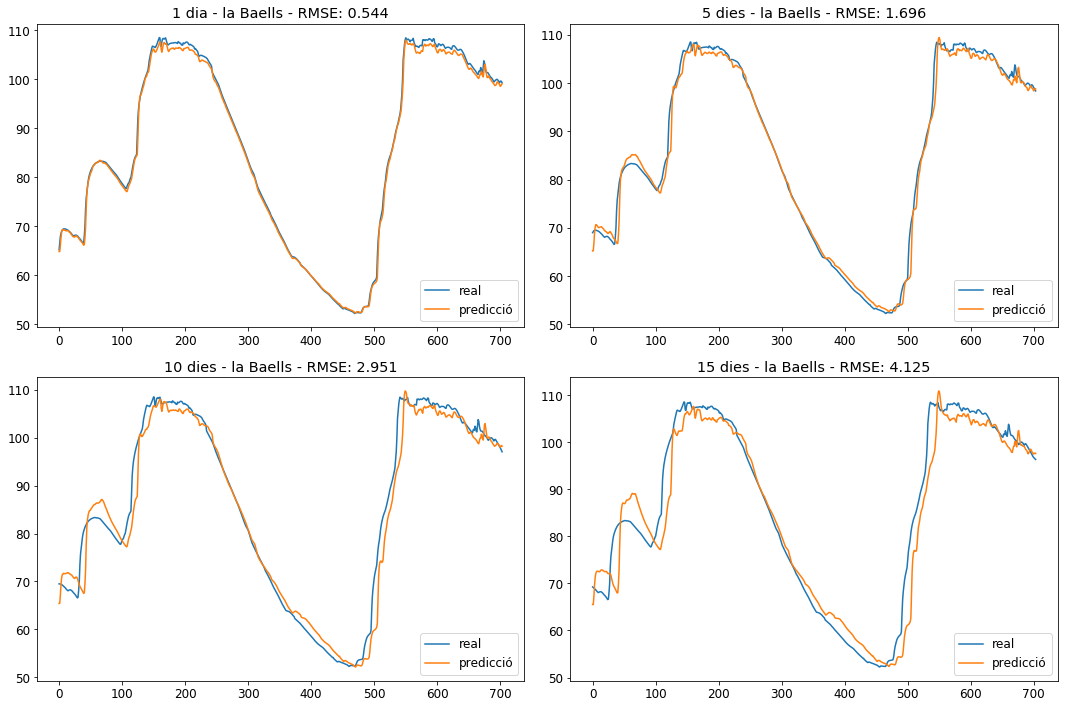

In [27]:
plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=4)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=4)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=4)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=4)


fig.tight_layout()
plt.show()

Optimitzem la mida de l'entrada del model

In [4]:
import numpy as np
n_steps_in = np.arange(5,101,2)
resultat = []
n_steps_out = 15
propTrainTest = 0.8

for entrades in n_steps_in:
    train_X, test_X, train_Y, test_Y = train_test(entrades, n_steps_out, propTrainTest, dataset)
    adam = optimizers.Adam(lr=0.0006)
    model = Sequential()
    model.add(Dense(30, activation='sigmoid', input_dim=entrades))
    model.add(Dense(n_steps_out))
    model.compile(loss='mse', optimizer=adam)
        # fit model
    modelfit = model.fit(train_X, train_Y, epochs=600, batch_size = 16, verbose=0)    
    
    testPredict = model.predict(test_X)
    # invertim prediccions per tenir-les en l'escala original
    testPredict = scaler.inverse_transform(testPredict)
    test_YR = scaler.inverse_transform(test_Y)
    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT, entrades)
    resultat.append((entrades, RMSE_TOT))

3.014770618914531 5
2.942349020778951 7
2.9512003583183612 9
2.8488356204100596 11
2.7934192294431184 13
2.7934245283095613 15
2.7729582846683836 17
2.726201091015728 19
2.7626988378261306 21
2.7028712139255617 23
2.6863031538938853 25
2.6407712135939234 27
2.723752809871934 29
2.6958294318948823 31
2.8512731434219534 33
2.733549938361787 35
2.7838171915609267 37
2.8886296200381754 39
2.759315980840159 41
2.8130800321131924 43
2.920605732666507 45
2.9270522408173196 47
2.789767901362475 49
2.8737036629485293 51
2.9865307758705026 53
2.770530246994947 55
2.8083933012113085 57
2.8190038094288083 59
2.80643024993585 61
2.8036101622845875 63
3.029387215922147 65
2.726949733810375 67
2.8142149593317143 69
2.7008899457537505 71
3.38192291035902 73
3.0962258720532883 75
2.7730338233696026 77
4.496496034761595 79
10.103622035473984 81
4.580445034217638 83
4.000238862660761 85
9.355169566023097 87
4.619525941191209 89
2.9123730431967183 91
5.460717443757426 93
6.2237472275943935 95
8.7056103993

In [5]:
import numpy as np
n_steps_in = np.arange(22,35,1)
resultat = []
n_steps_out = 15
propTrainTest = 0.8

for entrades in n_steps_in:
    train_X, test_X, train_Y, test_Y = train_test(entrades, n_steps_out, propTrainTest, dataset)
    adam = optimizers.Adam(lr=0.0006)
    model = Sequential()
    model.add(Dense(30, activation='sigmoid', input_dim=entrades))
    model.add(Dense(n_steps_out))
    model.compile(loss='mse', optimizer=adam)
        # fit model
    modelfit = model.fit(train_X, train_Y, epochs=600, batch_size = 16, verbose=0)    
    
    testPredict = model.predict(test_X)
    # invertim prediccions per tenir-les en l'escala original
    testPredict = scaler.inverse_transform(testPredict)
    test_YR = scaler.inverse_transform(test_Y)
    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT, entrades)
    resultat.append((entrades, RMSE_TOT))

2.6882131433836576 22
2.6851599405519258 23
2.654258930388808 24
2.7192347963422097 25
2.744204086542258 26
2.6582889819339632 27
2.6523883001686497 28
2.674330571083047 29
2.6842770503193196 30
2.7861915868931 31
2.7041828808151522 32
2.7203151089957185 33
2.712336460856021 34


In [7]:
n_steps_in = 30
n_steps_out = 15
propTrainTest = 0.8


train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, dataset)
adam = optimizers.Adam(lr=0.0006)
model = Sequential()
model.add(Dense(30, activation='sigmoid', input_dim=n_steps_in))
model.add(Dense(n_steps_out))
model.compile(loss='mse', optimizer=adam)
# fit model
modelfit = model.fit(train_X, train_Y, epochs=600, batch_size = 16, verbose=0)    
    
testPredict = model.predict(test_X)
# invertim prediccions per tenir-les en l'escala original
testPredict = scaler.inverse_transform(testPredict)
test_YR = scaler.inverse_transform(test_Y)
RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
print(RMSE_TOT)

2.656869271740972


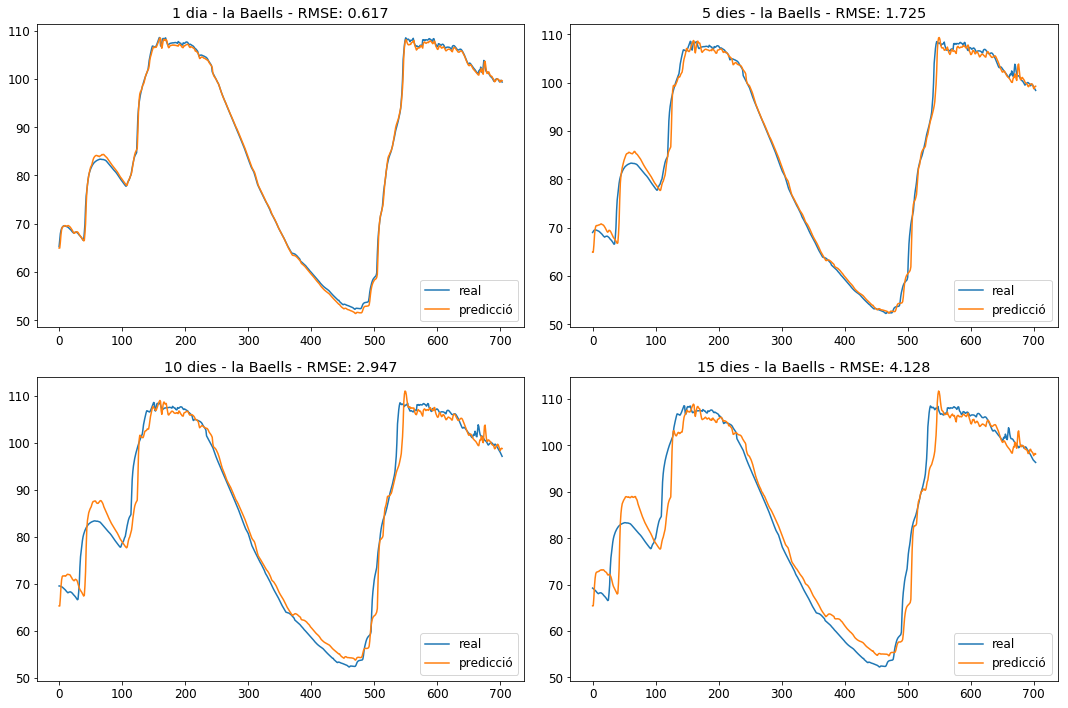

In [8]:
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - la Baells - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - la Baells - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - la Baells - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - la Baells - RMSE: '+str(round(RMSE_days[14],3))

plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=4)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=4)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=4)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=4)


fig.tight_layout()
plt.show()


In [10]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
def evaluate_forecasts_rquad(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        r_quad = r2_score(actual[:, i], predicted[:, i])
        mae = mean_absolute_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append((rmse,r_quad,mae,mse))
    # calcul global de RMSE
    s = 0
    r = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [11]:
RMSE_TOT, RMSE_days = evaluate_forecasts_rquad(test_YR,testPredict)
global_y = test_YR.reshape((test_YR.shape[0]*test_YR.shape[1], 1))
global_pred = testPredict.reshape((testPredict.shape[0]*testPredict.shape[1], 1))
r_quad = r2_score(global_y, global_pred)
rmse = sqrt(mean_squared_error(global_y, global_pred))
mse = mean_squared_error(global_y, global_pred)
mae = mean_absolute_error(global_y, global_pred)

res_globals=[rmse, r_quad, mae, mse]

resultsDF =  pd.DataFrame(RMSE_days)
resultsDF = resultsDF.T
resultsDF['Global'] = res_globals
resultsDF.columns=['dia 1','dia 2','dia 3','dia 4','dia 5','dia 6','dia 7','dia 8','dia 9','dia 10','dia 11','dia 12','dia 13','dia 14','dia 15', 'global']
resultsDF.rename(index={0:'RMSE',1:'R2',2:'MAE', 3:'MSE'}, inplace=True)
resultsDF = resultsDF.round(4)
display(resultsDF)

,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6,dia 7,dia 8,dia 9,dia 10,dia 11,dia 12,dia 13,dia 14,dia 15,global
RMSE,0.6169,0.8381,1.1413,1.4403,1.7248,1.9630,2.2343,2.4777,2.7224,2.9468,3.1735,3.4310,3.6359,3.9075,4.1279,2.6569
R2,0.9990,0.9981,0.9964,0.9943,0.9918,0.9894,0.9863,0.9832,0.9797,0.9761,0.9723,0.9676,0.9636,0.9580,0.9531,0.9806
MAE,0.4458,0.4686,0.6398,0.8215,1.0096,1.1825,1.4264,1.5726,1.7321,1.9691,2.1232,2.3887,2.5072,2.6741,2.8958,1.5905
MSE,0.3806,0.7024,1.3027,2.0746,2.9749,3.8534,4.9920,6.1389,7.4113,8.6836,10.0711,11.7719,13.2195,15.2682,17.0395,7.0590


In [12]:
RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
v = RMSE_days
ultim = v.append(RMSE_TOT)

dades_diesDF=pd.DataFrame(v)
dades_diesDF=dades_diesDF.round(3)
dades_diesDF=dades_diesDF.T
dades_diesDF.columns=['dia 1','dia 2','dia 3','dia 4','dia 5','dia 6','dia 7','dia 8','dia 9','dia 10','dia 11','dia 12','dia 13','dia 14','dia 15', 'global']
dades_diesDF.rename(index={0:'RMSE'}, inplace=True)

display(dades_diesDF)

,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6,dia 7,dia 8,dia 9,dia 10,dia 11,dia 12,dia 13,dia 14,dia 15,global
RMSE,0.617,0.838,1.141,1.44,1.725,1.963,2.234,2.478,2.722,2.947,3.173,3.431,3.636,3.907,4.128,2.657


In [13]:
resultsDF.to_csv('mlp-uni-baells.csv', sep=',', encoding='utf-8')

In [14]:
resultatsDEF=[]
for i, j in zip (test_YR, testPredict):
    resultatsDEF.append((i,j))
    
resultatsDEF = pd.DataFrame(resultatsDEF)
resultatsDEF.columns=['ytest','predict']
resultatsDEF.to_csv('mlp-uni-baells-test-predict.csv', sep=',', encoding='utf-8')